#  Organoid Recognition and Classification

Greg Lee
Last Edited: 01/04/20

Summary: Planning to use the pretrained model weights of DarkNet53, then modifying the last layer of the convolutional network to predict the bounding boxes of a single class - ie organoids. 

---
Architecture Choices: Detection Algorithms

 - YOLO Algorithm in the DarkNet Architecture. YOLO holds benefits as it is fast. Works by breaking down the image into smaller segments, analyzing what is within, and drawing bounding boxes, all in one go of the algorithm. Darknet is a framework to train neural networks while YOLO is the algorithmic architecture. Several versions exist to handle the different amounts of processing (layer depth and size)
    - PAPER TO READ: https://pjreddie.com/media/files/papers/YOLOv3.pdf
    - Explanation: https://martinapugliese.github.io/recognise-objects-yolo/
    - https://medium.com/@manivannan_data/how-to-train-yolov3-to-detect-custom-objects-ccbcafeb13d2
    - https://medium.com/coinmonks/detecting-custom-objects-in-images-video-using-yolo-with-darkflow-1ff119fa002f
    - Justification: N/A

 - R-CNNs
      - R-CNN's are more acurate. They implement a methodology of using some selection algorithm (later updated to a seperate NN) to propose regions of interest. Once found, these regions of interest are convolved into a vector and fed to an SVM for classification (multi-class enabled).Updates came with Fast R-CNN and Faster R-CNN. Fast RCNN uses pretrained feature extractor first, to create a feature map of the region of interest. Then pools the outputs, using a softmax node for class recognition and regressor for bounding boxes. Faster R-CNN attacks the region of interest proposing algorithm. Instead of using selective search, the algorithm takes the output of a pre-trained deep CNN and uses a small network to examine the feature map and produce multiple region proposals and class predictions. Region proposals are based on anchor-boxes. 
      - https://machinelearningmastery.com/object-recognition-with-deep-learning/

 - Single Shot Multibox Detector (SSD)
 
 - Histograms of Oriented Gradients (HOG)~ 2005
     - Use combination of HOG and SCale Invariant Feature transformation to identify interest points within images based on normalized local histograms of image gradients. 
         - SIFT: Computer vision alg. that identifies and encapsulates the infromation on local points of interest within an image to describe the objects within the image bases on the extracted features
     - Method based on the assumption that objects have distinct sets of characteristics that can be identified by the local intensity of gradients and edge direction on aper-window basis. 
     - Affine Invariant: Affine transformations are a combination of a translation with a linear transformation which preserves points and straight lines. 
     - Uses an SVM to detect objects of interest based on the HOG descriptors. 
 - Haar Features: 
     - Charactersitics of a section of an image can be captured by comparing the pixel intensities of two neighboring rectangular regions and finding the difference between the summation. 
     - Good for images which don't change and are always taken at the same aspect ratio. 
     - Ie Face Detection (EYES)
--- 

Intent of the Project: Attempt to use the YOLO algorithm to quickly predict organoid numbers. As such, this would allow researchers to quantify organoids with a camera attached to a microscope, doing real-time processing of images, instead of having to take pictures of organoid gels. 

In [ ]:
Links: 
https://medium.com/@manivannan_data/how-to-train-yolov3-to-detect-custom-objects-ccbcafeb13d2
https://www.kdnuggets.com/2018/09/data-augmentation-bounding-boxes-image-transforms.html

# Libraries: 

In [1]:
#Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Image Libraries : 
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image

#Machine Learning Libraries
#import tensorflow as tf

from sklearn.model_selection import train_test_split

# Import Data: 

In [51]:
#Grab Data: 
directory = './Images_V2'
org_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

#Data Shape: 
print("Core Dataset: {0} images".format(len(org_files)))

Core Dataset: 1240 images


Organoids are 3D cell aggregates, grown from harvested stem cells. These images are mice intestinal organoids from the Li Lab at the University of Utah. 

Protocol for grown organoids is as follows: 
C57BL/6J (wildtype) were purchased from Jackson Laboratories. All male and female mice used for intestinal crypt isolation were adults (8–10 weeks old). The isolation procedure was modified from an established protocol [1]. The jejunal sections of the mouse’s small intestine was harvested, opened longitudinally and washed with ice cold 1x phosphate buffer saline (PBS) (Sigma-Aldrich). Mucus and villi were removed using a thin glass coverslip and tissue was cut into 1 cm sections. The tissue pieces were washed in cold PBS and incubated in 30 mM ethylenediaminetetraacetic acid (EDTA) (Sigma-Aldrich), dissolved in PBS, for 8 minutes on ice. Under harsh stripping conditions, dithiothreitol (DTT) (Thermo-Fisher) was added to this solution at a concentration of 1.5 mM. Tissue pieces were transferred to PBS and incubated for 15 minutes on ice. Crypts were liberated by vigorously shaking for 3 minutes and isolated by passage through a 70 mm cell strainer. Purified crypts were pelleted by centrifugation (300 g for 5 minutes at 23 degrees C) and washed twice with PBS to remove any remaining contaminants. All animal studies were approved by University of Utah Institutional Animal Care and Use Committee under protocol number 16-05012 and 18-02010. All animal experiments were conducted in accordance with National Institute of Health Guide for the Care and Use of Laboratory Animals [2].

Isolated crypts were counted then pelleted by centrifugation (300 g for 5 minutes at 23 degrees C). 1000 crypts were suspended in 80 mL of 50% growth-factor-reduced phenol-red-free Matrigel (Corning) diluted in conditioned LWRN culture medium containing WNT3a, R-spondin, and Noggin (preparation previously described [3]). This suspension was pipetted onto the center of a 24 well plate to create a dome. Each gel polymerized at 37°C for 20 minutes. 750 mL of media containing a treatment (singularly including b-estradiol (Sigma-Aldrich), 4-hydroxytamoxifen (Cayman), and G15 (Tocris)) was added to fully submerge the gel. Media was changed every 3 to 4 days, with treatment maintenance throughout. Organoids were counted under 4x magnification with images captured on the EVOSTM Auto Imaging System 4 and 7 days after plating. The number of organoids was normalized per each experiment. 

The images used for this project represent organoids, seven days after seeding. While other organoid systems exist, this algorithm is intended for quantifying the total number of intestinal organoids in a given frame. 

[1] Hamilton KE, Crissey MA, Lynch JP, et al. (2015, May.). Culturing adult stem cells from mouse small intestinal crypts. Cold Spring Harbor Protocols.1940-3402.
[2] Health Nlo. (2011). Guide for the Care and Use of Laboratory Animals. 8th Edition. Washington, DC, USA: National Academies Press. 
[3]	Miyoshi H, Stappenbeck TS. (2013, Nov.). In vitro expansion and genetic modification of gastrointestinal stem cells in spheroid culture. Nat Protoc. 8:2471 – 2482. 


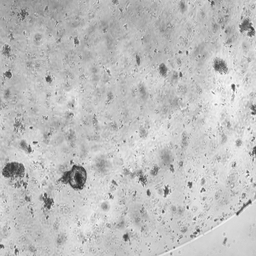

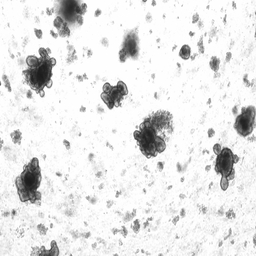

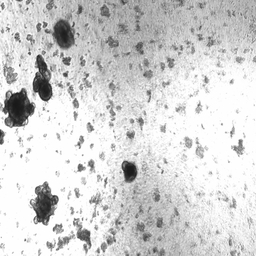

In [52]:
#Sample Images from Data
display(_Imgdis(filename=directory + "/" + onlyfiles[0], width=200, height=200))
display(_Imgdis(filename=directory + "/" + onlyfiles[1], width=200, height=200))
display(_Imgdis(filename=directory + "/" + onlyfiles[1232], width=200, height=200))

## Data Exploration

In [72]:
#Get Ordered File Directory: Image names
directory = './Images_V2/'
onlyfiles = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

#Add filenames to DataFrame and Sort
filenames = pd.DataFrame(onlyfiles, columns=['FileNames']) 
sorted_filenames = filenames.sort_values('FileNames')
sorted_filenames =sorted_filenames.iloc[1:].reset_index(drop = True)
sorted_filenames.head() 

,FileNames
0,0002_resize.jpg
1,0003_resize.jpg
2,0004_resize.jpg
3,0005_resize.jpg
4,0006_resize.jpg


In [74]:
#Get Ordered File Directory: Image Label Files
directory = './Image_Labels_V2/'
only_filenames = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

#Add filenames to DataFrame and Sort
label_filenames = pd.DataFrame(only_filenames, columns=['Label_FileNames']) 
label_filenames = label_filenames.sort_values('Label_FileNames')
label_filenames =label_filenames.reset_index(drop = True)
sorted_filenames['Label_FileNames']  = label_filenames
sorted_filenames.head()

,FileNames,Label_FileNames
1234,1237_resize.jpg,1237_resize.txt
1235,1238_resize.jpg,1238_resize.txt
1236,1239_resize.jpg,1239_resize.txt
1237,1240_resize.jpg,1240_resize.txt
1238,1241_resize.jpg,1241_resize.txt


In [89]:
#For each .jpg and .txt file --> expand the file and put the contents into a dictionary: 
labels = []
tot_organs = []
images = []

for i in range(sorted_filenames.shape[0]):
    #Collect the image pixel values
    img = Image.open('./Images_V2/' + sorted_filenames['FileNames'].iloc[i]).convert('RGB')
    image = np.array(img)
    
    #Collecting infromation on the label:
    try: 
        temp_cont = pd.read_csv(directory + sorted_filenames['Label_FileNames'].iloc[i],header = None, sep = " ")
        label = temp_cont.values
        tot_org = len(label)
    
    
    except:
        #Some images have no organoids within. We will set the label as a NaN and Total organoids to 0
        label = np.array([np.nan])
        tot_org = 0
        
    labels.append(label)
    tot_organs.append(tot_org)
    images.append(image)
    
sorted_filenames['Label'] = labels
sorted_filenames['Total_Organoids'] = tot_organs
sorted_filenames['Image'] = images
sorted_filenames.head()

,FileNames,Label_FileNames,Label,Total_Organoids,Image
0,0002_resize.jpg,0002_resize.txt,"[[0.0, 0.478516, 0.429688, 0.136719, 0.1484380...",1,"[[[206, 206, 206], [206, 206, 206], [206, 206,..."
1,0003_resize.jpg,0003_resize.txt,"[[0.0, 0.6679689999999999, 0.410156, 0.070312,...",2,"[[[139, 139, 139], [124, 124, 124], [126, 126,..."
2,0004_resize.jpg,0004_resize.txt,"[[0.0, 0.35742199999999996, 0.765625, 0.113280...",4,"[[[133, 133, 133], [131, 131, 131], [135, 135,..."
3,0005_resize.jpg,0005_resize.txt,"[[0.0, 0.617188, 0.6523439999999999, 0.109375,...",5,"[[[136, 136, 136], [133, 133, 133], [129, 129,..."
4,0006_resize.jpg,0006_resize.txt,"[[0.0, 0.8261719999999999, 0.462891, 0.160156,...",5,"[[[223, 223, 223], [222, 222, 222], [217, 217,..."


## Visualization and Desc. Stats

Text(0.5, 1.0, 'Histogram: Organoids per Image')

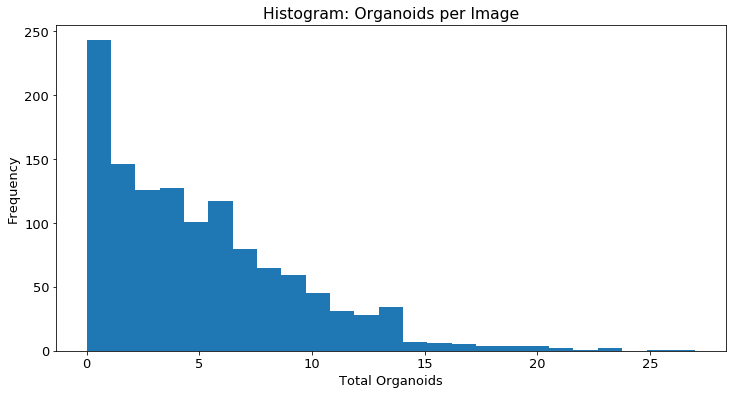

In [107]:
#Visualize histogram of label distribution
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sorted_filenames['Total_Organoids'].plot.hist(bins = 25, ax = ax)
ax.set_xlabel("Total Organoids")
ax.set_title('Histogram: Organoids per Image')

In [108]:
sorted_filenames['Total_Organoids'].describe()

count    1239.000000
mean        5.234867
std         4.084394
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        27.000000
Name: Total_Organoids, dtype: float64

In [109]:
print(sorted_filenames['Total_Organoids'].median())

4.0


**Conclusion**
1. In total there are 1,239 labeled organoid images. 
2. Overall it appears the distribution of organoids is heavily skewed to the right. Most of the selected images appear to have under 10 total organoids. This detail is important for those considering using this classifier on more densely seeded organoid cultures.
3. On average there are roughly 5 total organoids per image. The media of the data is 4, perhaps a better metric for the middle of the data based on the skew. 

# Data Augmentation to Expand Data Size:

This initial grouping of images is relatively small. In order to scale-up the size of the data, we can leverage data augmentation. Employed are the following transformations: 
1. 
2. 

# Running: 03.02.20:
Result: Darknet threw a segmentation fault. Looking at the documentation, this looks like it may be related to either the labels (some having 0.0s) or related to memory. Tried making predictions with the output (had trained 300 times) ended up getting nothing until threshold below 0.2, then many bounding boxes were classified as organoids. Going to reformat and try training tiny_yolo. This will cross one portion of trouble shooting off. 

#Tiny Test: 
Created a new Organoid_tiny.data and Organoid_tiny.cfg

Organoid_tiny.data:
classes = 1
train = /Users/greglee/Data_Science/darknet/train.txt
valid = /Users/greglee/Data_Science/darknet/test.txt
names = /Users/greglee/Data_Science/darknet/org_classes.names
backup = /Users/greglee/Data_Science/darknet/backup

Organoid_tiny.cfg:
    
    [net]
Testing
#batch=24
#subdivisions=1
Training
batch=24
subdivisions=8
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

[convolutional]
batch_normalize=1
filters=16
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=1

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=1
pad=1
activation=leaky

###########

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=18
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=1
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 8

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=18
activation=linear

[yolo]
mask = 0,1,2
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=1
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1


ran: ./darknet detector train cfg/Organoid_tiny.data cfg/Organoid_tiny.cfg darknet53.conv.74

# Extra Functions 

In [3]:
#Function to standardize numerical names seperated by  "_"
def name_num_standardize(directory, placeholders, follow_name):
    
    """
    Standardizes files with lists of numbered data. Fills with zeros to a desired length.
    
    Arguments:
    directory -- Computer path to file
    placeholders -- The desired number of placeholder values
    follow_name -- File type and rest of name. All files should maintain this as identical.
        
    Returns:
    No returns. Should edit the files directly!
    """
    for file in os.listdir(directory):
        new_name = file.split("_",1)[0].zfill(placeholders) + follow_name
        os.rename(directory + file, directory + new_name)  
    

In [4]:
#Run on Data: 
#COMMENT IN IF DATA NEEDS TO BE CHANGED

#name_num_standardize(directory = './Images/',placeholders = 4, follow_name = '_resize.jpg')
#name_num_standardize(directory = './Image_Labels/',placeholders = 4, follow_name = '_resize.txt')

# What is the best way to order the data for training? Need to import the images as matrix stack? What about the labels for the data? Look at the best way to do this for YOLO? 

Ok...So we trying an open-source implementation first to see if we can get this thing up and running. If it works, then I'm gonna need to decide if I want to go back in and do a custom build of the tensorflow code. Pjreddie did a version which seems to be used most often of darknet with YOLOv3 with tensorflow. 
 - Source: https://towardsdatascience.com/tutorial-build-an-object-detection-system-using-yolo-9a930513643a 

In [6]:
#to split the sorted_filenames dataframe into two groups: 
from sklearn.model_selection import train_test_split
train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(sorted_filenames, sorted_filenames, test_size=0.19, random_state=2)

#Note: According to this implementation, I only need to provide the directories of the training/test files. Not change the images as well

#What are the sizes?
print("Using a total split of 81% training and 19% testing")
print("The size of the training set is : %d" % train_set_x.shape[0])
print("The size of the validation set is : %d" % test_set_x.shape[0])

Using a total split of 81% training and 19% testing
The size of the training set is : 1003
The size of the validation set is : 236


In [7]:
train_set_x.head()

,FileNames
297,0888_resize.jpg
750,0546_resize.jpg
1061,0983_resize.jpg
35,0382_resize.jpg
913,0766_resize.jpg


In [17]:
#Let's save each as train.txt and test.txt with full extension

#TRAINING SPLIT
train_labels_with_path = pd.DataFrame(columns =["FileNames"])
#Add Path: 
train_labels_with_path['FileNames'] = '/Users/greglee/Data_Science/darknet/Org_darknet/JPEGImage/' + train_set_x['FileNames'].astype(str)
#Save File
train_labels_with_path.to_csv('train.txt',sep='\n',index = False,header = False)

#TEST SPLIT
test_labels_with_path = pd.DataFrame(columns =["FileNames"])
#Add Path: 
test_labels_with_path['FileNames'] = '/Users/greglee/Data_Science/darknet/Org_darknet/JPEGImage/' + test_set_x['FileNames'].astype(str)
test_labels_with_path.to_csv('test.txt',sep='\n',index = False,header = False) 

In [20]:
image = open('/Users/greglee/Data_Science/darknet/Org_darknet/JPEGImage/0879_resize.jpg')

# New Update: 01.20.20

BUG FOUND. Turns out images and labels need to be within the same directory. Wahoo. 

Not all the files are indexed or labeled correctly. Time to do some quality control on what is missing. Going to write a script to compare the .jpg names to .txt names (using a pandas join maybe?) to find out what which files are missing. Know I also need to deal with number 500 which says big boi....Then will probably need to reindex all the files. 

In [28]:
#Let's get all the names sorted out: 
path = '/Users/greglee/Data_Science/darknet/Org_darknet/JPEGImage'

#Better to have an empty constructor for strings apparently
jpg_L = []
txt_L = []

for f in os.listdir(path):
    if (f.split('.')[1] == 'jpg'):
        jpg_L.append(f)
        
    if (f.split('.')[1] == 'txt'):
        txt_L.append(f)

jpg_df = pd.DataFrame(jpg_L,columns =['full'])
txt_df = pd.DataFrame(txt_L,columns =['full'])   


jpg_df[['Base','Extension']] = jpg_df.full.str.split('.',expand = True)
txt_df[['Base','Extension']] = txt_df.full.str.split('.',expand = True)



#Join the Dataframes: 
join = txt_df.merge(jpg_df,left_on='Base', right_on='Base',how='outer')
join = join.sort_values(by = ['full_x'])

In [29]:
#These are all missing text files
test = join.iloc[1224:]
test.sort_values(by = "Base")

,full_x,Base,Extension_x,full_y,Extension_y
1024,1227_resize.txt,1227_resize,txt,1227_resize.jpg,jpg
683,1228_resize.txt,1228_resize,txt,1228_resize.jpg,jpg
206,1229_resize.txt,1229_resize,txt,1229_resize.jpg,jpg
104,1230_resize.txt,1230_resize,txt,1230_resize.jpg,jpg
864,1231_resize.txt,1231_resize,txt,1231_resize.jpg,jpg
448,1232_resize.txt,1232_resize,txt,1232_resize.jpg,jpg
1206,1233_resize.txt,1233_resize,txt,1233_resize.jpg,jpg
640,1234_resize.txt,1234_resize,txt,1234_resize.jpg,jpg
154,1235_resize.txt,1235_resize,txt,1235_resize.jpg,jpg
983,1236_resize.txt,1236_resize,txt,1236_resize.jpg,jpg


In [33]:
#Missing Values have been taken care of. Now able to train darknet!
#https://github.com/tzutalin/labelImg

def empty_file(path,file_name):
    with open(os.path.join(path, file_name), 'w') as fp: 
        pass

empty_file('/Users/greglee/Desktop','test.txt')